# Sentiment Classification with Logistic Regression and LSTM

This notebook implements a sentiment analysis system using Logistic Regression and LSTM on a movie review dataset. It includes data loading, preprocessing, model training, hyperparameter tuning, model saving, and a prediction function for user input. Experiment tables capture variations in parameters like learning rate, batch size, optimizer, and feature engineering.

# Sentiment Analysis - Group Assignment
## Group 1 Members:

*   Humphrey Jones Gabarinocheka Nyahoja

*   Samuel Dushime

*   Audry Ashleen Chivanga

*   Jules Gatete


## Step 1: Import Libraries

Install and import necessary libraries for data processing, modeling, and evaluation.

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
import nltk
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samenergy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/samenergy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Step 2: Load and Preprocess Data

Load the dataset from `IMDB Dataset.csv` and clean the text by removing HTML tags, punctuation, and stopwords.

In [53]:
# Load data
df = pd.read_csv('/Users/samenergy/Documents/Projects/alu-ml_tech1-assignment/Dataset/IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Text cleaning function
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Lowercase
    tokens = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning
df['clean_review'] = df['review'].apply(clean_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment'], test_size=0.2, random_state=42)
print('Training set size:', len(X_train))
print('Test set size:', len(X_test))

Training set size: 40000
Test set size: 10000


## Step 3: Feature Engineering

Prepare features for Logistic Regression (TF-IDF and Count Vectorizer) and LSTM (tokenization and padding).

In [54]:
# TF-IDF for Logistic Regression
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Count Vectorizer as alternative
count_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Tokenization and padding for LSTM
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

## Step 4: Logistic Regression Training and Tuning

Train Logistic Regression with different hyperparameters (C, solver, vectorizer) and save the best model.

In [55]:
# Logistic Regression function
def train_logistic_regression(X_train, y_train, X_test, y_test, C, solver, vectorizer_type):
    model = LogisticRegression(C=C, solver=solver, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'C': C,
        'solver': solver,
        'vectorizer': vectorizer_type,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'model': model
    }

# Experiments
logistic_experiments = [
    {'C': 0.1, 'solver': 'liblinear', 'vectorizer': 'TF-IDF'},
    {'C': 1.0, 'solver': 'liblinear', 'vectorizer': 'TF-IDF'},
    {'C': 1.0, 'solver': 'saga', 'vectorizer': 'TF-IDF'},
    {'C': 0.1, 'solver': 'liblinear', 'vectorizer': 'Count'},
    {'C': 1.0, 'solver': 'liblinear', 'vectorizer': 'Count'}
]
logistic_results = []
best_logistic_model = None
best_logistic_f1 = 0
best_vectorizer = None

for params in logistic_experiments:
    X_train_vec = X_train_tfidf if params['vectorizer'] == 'TF-IDF' else X_train_count
    X_test_vec = X_test_tfidf if params['vectorizer'] == 'TF-IDF' else X_test_count
    result = train_logistic_regression(X_train_vec, y_train, X_test_vec, y_test, params['C'], params['solver'], params['vectorizer'])
    logistic_results.append({k: v for k, v in result.items() if k != 'model'})
    if result['f1'] > best_logistic_f1:
        best_logistic_f1 = result['f1']
        best_logistic_model = result['model']
        best_vectorizer = tfidf_vectorizer if params['vectorizer'] == 'TF-IDF' else count_vectorizer

# Save best model and vectorizer
joblib.dump(best_logistic_model, 'best_logistic_model.pkl')
joblib.dump(best_vectorizer, 'vectorizer.pkl')

# Display results
print('Logistic Regression Results:')
print(pd.DataFrame(logistic_results)[['vectorizer', 'C', 'solver', 'accuracy', 'precision', 'recall', 'f1']])

Logistic Regression Results:
  vectorizer    C     solver  accuracy  precision    recall        f1
0     TF-IDF  0.1  liblinear    0.8750   0.861477  0.896011  0.878405
1     TF-IDF  1.0  liblinear    0.8949   0.885240  0.909307  0.897112
2     TF-IDF  1.0       saga    0.8949   0.885240  0.909307  0.897112
3      Count  0.1  liblinear    0.8910   0.885268  0.900377  0.892759
4      Count  1.0  liblinear    0.8746   0.874827  0.876563  0.875694


## Step 5: Define LSTM Model Function

Define the function to build the LSTM model with specified hyperparameters.

In [56]:
def build_lstm_model(embedding_dim, lstm_units, dropout_rate, learning_rate, optimizer):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        LSTM(lstm_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'Nadam':
        opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Evaluation and Visualization Function

Define a function to compute metrics and generate visualizations for each experiment.

In [57]:
def evaluate_and_visualize(model, X_test_pad, y_test, history, params, experiment_id):
    # Compute metrics
    y_pred = (model.predict(X_test_pad) > 0.5).astype(int)
    metrics = {
        'embedding_dim': params['embedding_dim'],
        'lstm_units': params['lstm_units'],
        'dropout_rate': params['dropout_rate'],
        'learning_rate': params['learning_rate'],
        'batch_size': params['batch_size'],
        'optimizer': params['optimizer'],
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    
    # Print metrics
    print(f'\nExperiment {experiment_id} Results:')
    print(pd.DataFrame([metrics])[['embedding_dim', 'lstm_units', 'dropout_rate', 'learning_rate', 'batch_size', 'optimizer', 'accuracy', 'precision', 'recall', 'f1']])
    
    # Visualizations
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - Experiment {experiment_id}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.show()
    
    # 2. ROC Curve
    y_pred_proba = model.predict(X_test_pad)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Experiment {experiment_id}')
    plt.legend(loc='lower right')
    plt.show()
    
    # 3. Training and Validation Loss/Accuracy
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - Experiment {experiment_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - Experiment {experiment_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return metrics

## Run Experiment 1

Parameters: embedding_dim=50, lstm_units=64, dropout_rate=0.3, learning_rate=0.001, batch_size=32, optimizer=Adam

Epoch 1/15


/Users/samenergy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.7641 - loss: 0.4629 - val_accuracy: 0.8825 - val_loss: 0.2928
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9201 - loss: 0.2175 - val_accuracy: 0.8817 - val_loss: 0.2887
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9452 - loss: 0.1515 - val_accuracy: 0.8794 - val_loss: 0.3264
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9608 - loss: 0.1150 - val_accuracy: 0.8737 - val_loss: 0.3702
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9736 - loss: 0.0782 - val_accuracy: 0.8684 - val_loss: 0.4633
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9806 - loss: 0.0591 - val_accuracy: 0.8665 - val_loss: 0.4518
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9844 - loss: 0.0478 - val_accuracy: 0.8712 - val_loss: 0.5413
Epoch 8/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9916 - loss: 0.03

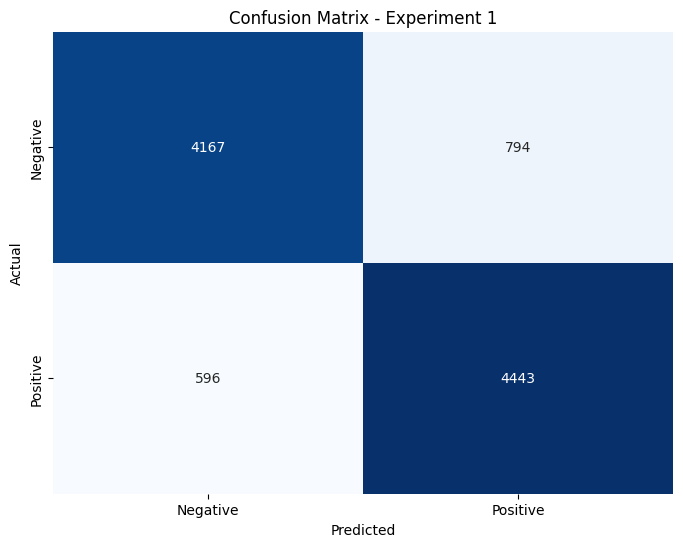

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


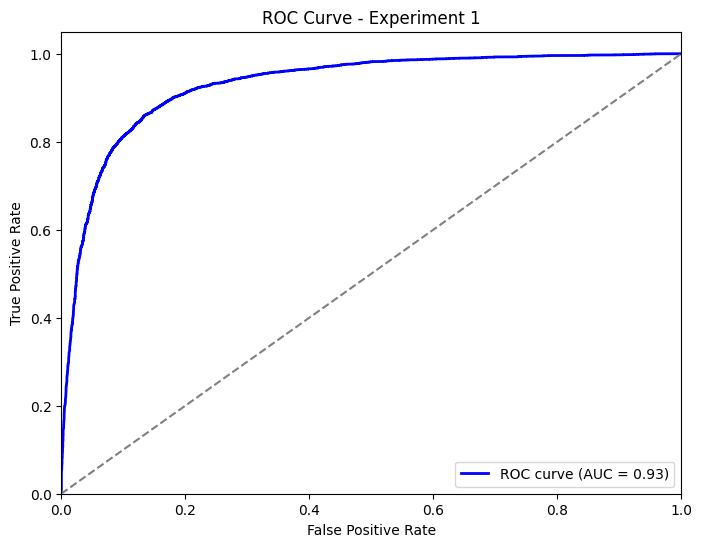

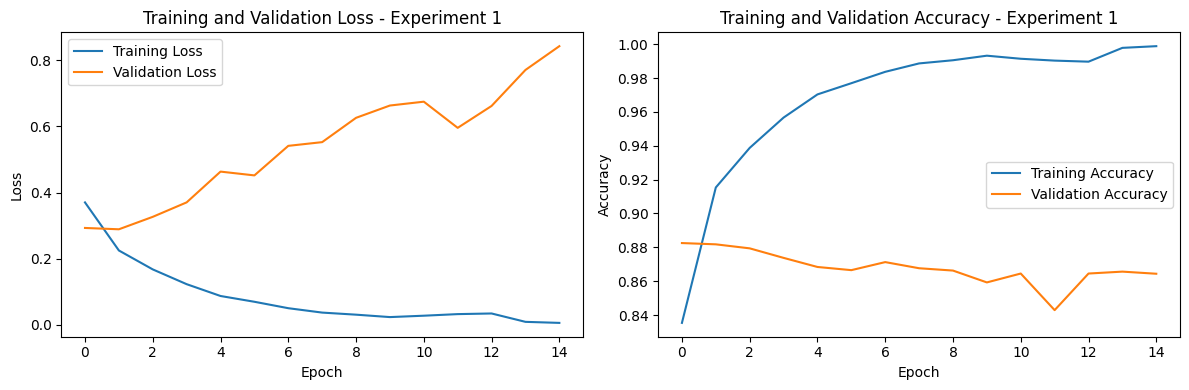

In [58]:
params_1 = {'embedding_dim': 50, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam'}
model_1 = build_lstm_model(params_1['embedding_dim'], params_1['lstm_units'], params_1['dropout_rate'], params_1['learning_rate'], params_1['optimizer'])
history_1 = model_1.fit(X_train_pad, y_train, batch_size=params_1['batch_size'], epochs=15, validation_split=0.2, verbose=1)
metrics_1 = evaluate_and_visualize(model_1, X_test_pad, y_test, history_1, params_1, 1)

## Run Experiment 2

Parameters: embedding_dim=100, lstm_units=64, dropout_rate=0.5, learning_rate=0.001, batch_size=64, optimizer=Adam

Epoch 1/15


/Users/samenergy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.7395 - loss: 0.5159 - val_accuracy: 0.8852 - val_loss: 0.2767
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.9213 - loss: 0.2156 - val_accuracy: 0.8826 - val_loss: 0.2948
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9482 - loss: 0.1488 - val_accuracy: 0.8739 - val_loss: 0.3242
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9623 - loss: 0.1114 - val_accuracy: 0.8781 - val_loss: 0.3496
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9707 - loss: 0.0872 - val_accuracy: 0.8705 - val_loss: 0.4602
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9798 - loss: 0.0630 - val_accuracy: 0.8571 - val_loss: 0.4897
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9865 - loss: 0.0478 - val_accuracy: 0.8660 - val_loss: 0.5012
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9826 - loss: 0.0574 - val_accurac

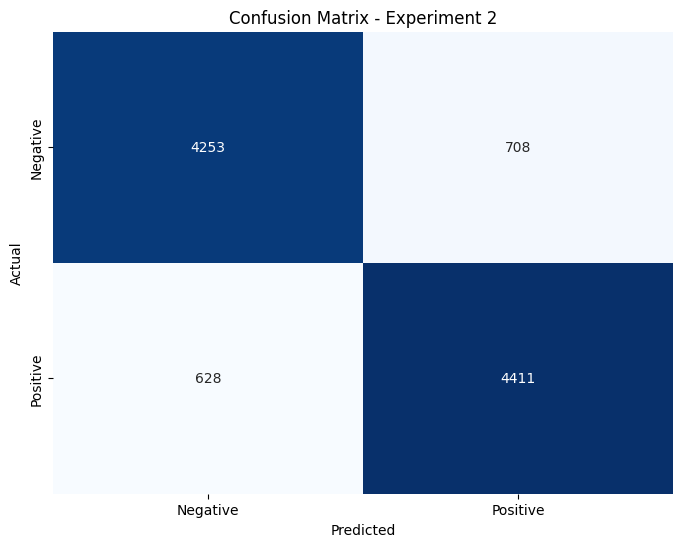

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


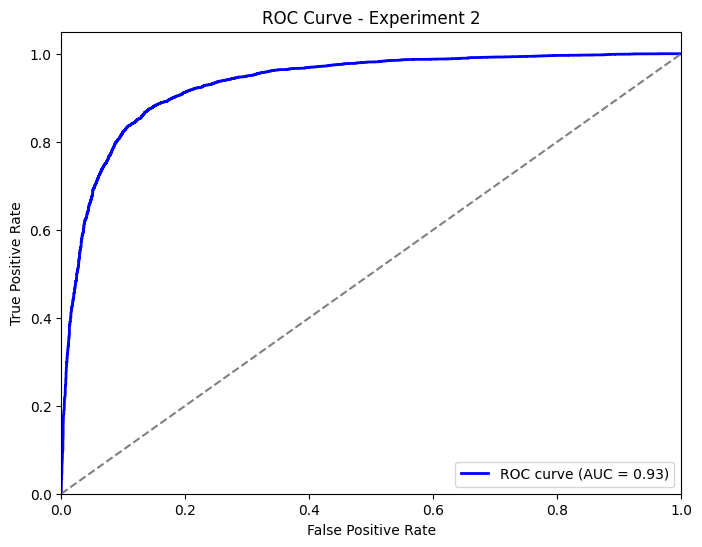

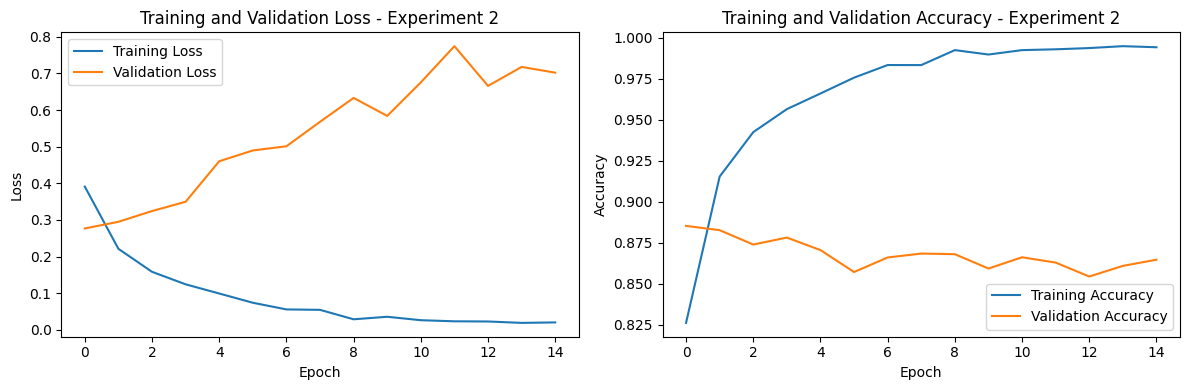

In [59]:
params_2 = {'embedding_dim': 100, 'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'Adam'}
model_2 = build_lstm_model(params_2['embedding_dim'], params_2['lstm_units'], params_2['dropout_rate'], params_2['learning_rate'], params_2['optimizer'])
history_2 = model_2.fit(X_train_pad, y_train, batch_size=params_2['batch_size'], epochs=15, validation_split=0.2, verbose=1)
metrics_2 = evaluate_and_visualize(model_2, X_test_pad, y_test, history_2, params_2, 2)

## Run Experiment 3

Parameters: embedding_dim=100, lstm_units=128, dropout_rate=0.5, learning_rate=0.0005, batch_size=32, optimizer=Nadam

Epoch 1/15


/Users/samenergy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 50ms/step - accuracy: 0.7638 - loss: 0.4654 - val_accuracy: 0.8904 - val_loss: 0.2761
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.9227 - loss: 0.2058 - val_accuracy: 0.8839 - val_loss: 0.3030
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.9466 - loss: 0.1493 - val_accuracy: 0.8774 - val_loss: 0.3310
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.9582 - loss: 0.1142 - val_accuracy: 0.8765 - val_loss: 0.3568
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.9716 - loss: 0.0874 - val_accuracy: 0.8719 - val_loss: 0.4481
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.9779 - loss: 0.0630 - val_accuracy: 0.8721 - val_loss: 0.4530
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.9839 - loss: 0.0512 - val_accuracy: 0.8649 - val_loss: 0.5337
Epoch 8/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.9836 - loss: 0.05

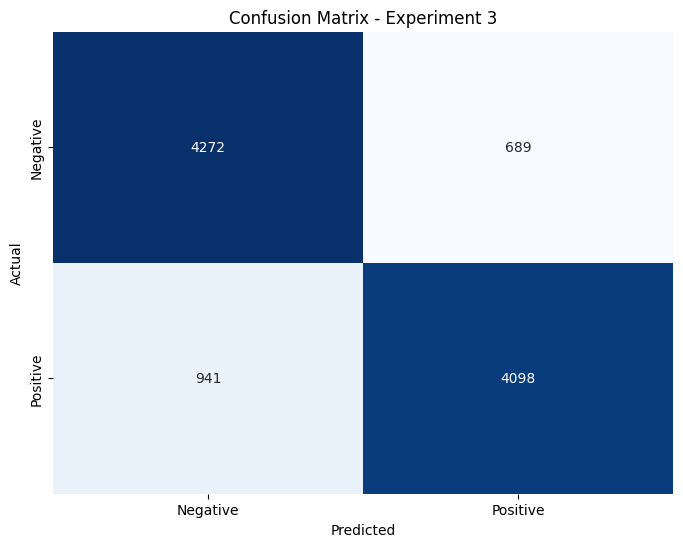

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


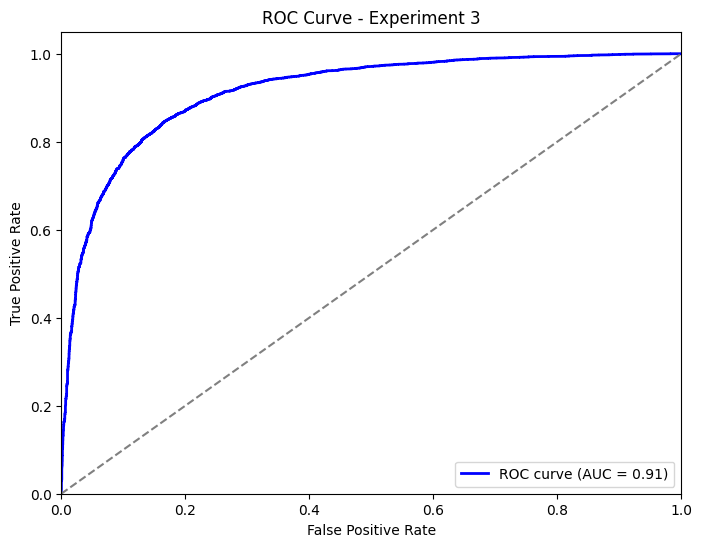

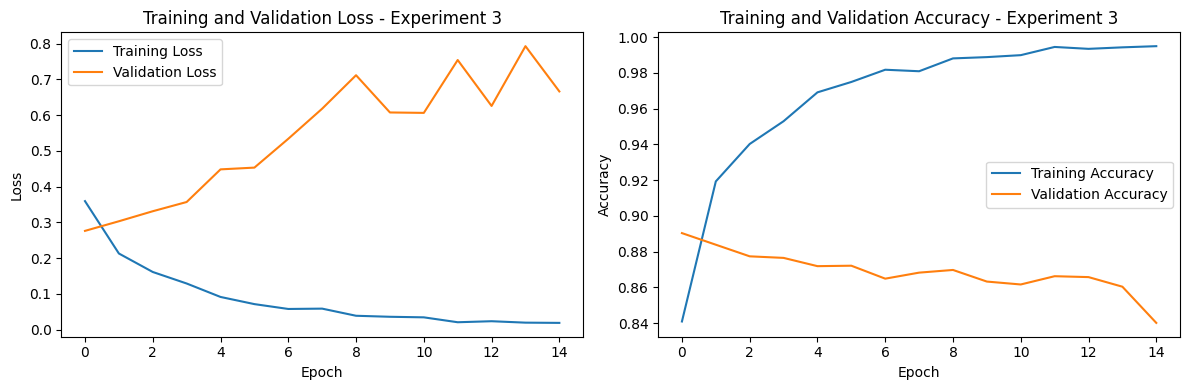

In [60]:
params_3 = {'embedding_dim': 100, 'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'optimizer': 'Nadam'}
model_3 = build_lstm_model(params_3['embedding_dim'], params_3['lstm_units'], params_3['dropout_rate'], params_3['learning_rate'], params_3['optimizer'])
history_3 = model_3.fit(X_train_pad, y_train, batch_size=params_3['batch_size'], epochs=15, validation_split=0.2, verbose=1)
metrics_3 = evaluate_and_visualize(model_3, X_test_pad, y_test, history_3, params_3, 3)

## Run Experiment 4

Parameters: embedding_dim=50, lstm_units=64, dropout_rate=0.3, learning_rate=0.001, batch_size=32, optimizer=Nadam

Epoch 1/15


/Users/samenergy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7827 - loss: 0.4432 - val_accuracy: 0.8825 - val_loss: 0.2894
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9223 - loss: 0.2064 - val_accuracy: 0.8848 - val_loss: 0.2920
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9478 - loss: 0.1491 - val_accuracy: 0.8811 - val_loss: 0.3418
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9618 - loss: 0.1150 - val_accuracy: 0.8791 - val_loss: 0.3534
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9682 - loss: 0.0946 - val_accuracy: 0.8701 - val_loss: 0.4057
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9792 - loss: 0.0650 - val_accuracy: 0.8691 - val_loss: 0.4489
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9803 - loss: 0.0613 - val_accuracy: 0.8706 - val_loss: 0.4805
Epoch 8/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9887 - loss: 0.03

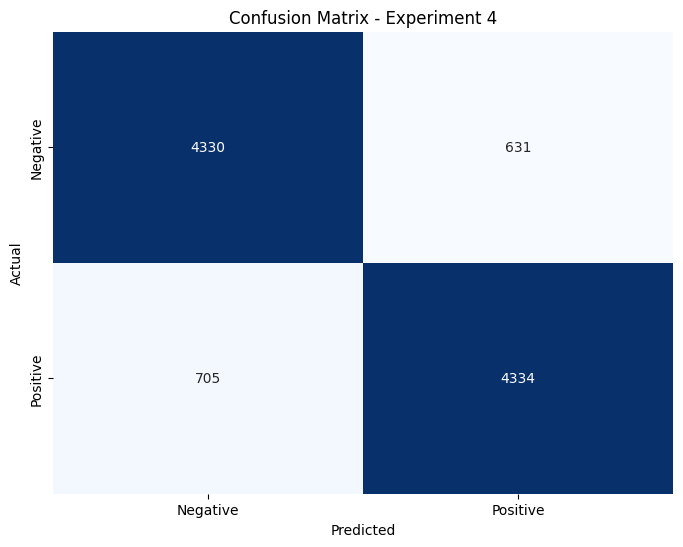

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


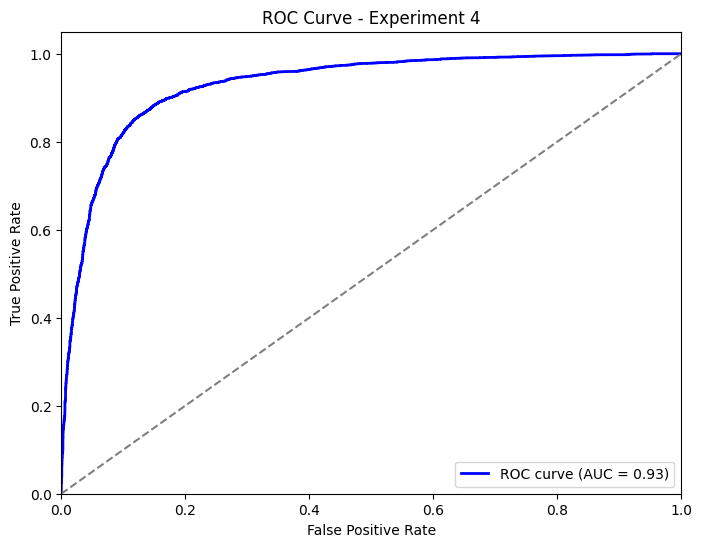

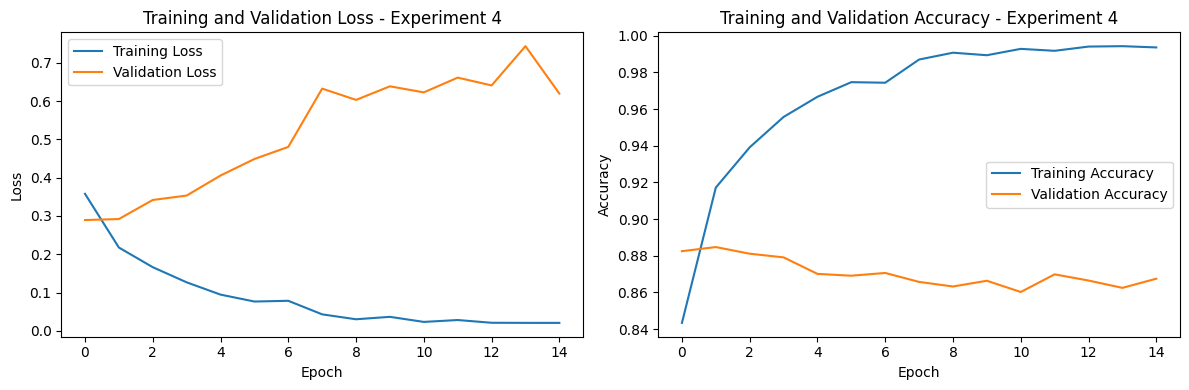

In [61]:
params_4 = {'embedding_dim': 50, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Nadam'}
model_4 = build_lstm_model(params_4['embedding_dim'], params_4['lstm_units'], params_4['dropout_rate'], params_4['learning_rate'], params_4['optimizer'])
history_4 = model_4.fit(X_train_pad, y_train, batch_size=params_4['batch_size'], epochs=15, validation_split=0.2, verbose=1)
metrics_4 = evaluate_and_visualize(model_4, X_test_pad, y_test, history_4, params_4, 4)

## Compare Experiments and Save Best Model

Combine results, identify the best model based on F1-score, and save it along with the tokenizer.

All LSTM Experiment Results:
   embedding_dim  lstm_units  dropout_rate  learning_rate  batch_size  \
0             50          64           0.3         0.0010          32   
1            100          64           0.5         0.0010          64   
2            100         128           0.5         0.0005          32   
3             50          64           0.3         0.0010          32   

  optimizer  accuracy  precision    recall        f1  
0      Adam    0.8610   0.848386  0.881723  0.864733  
1      Adam    0.8664   0.861692  0.875372  0.868478  
2     Nadam    0.8370   0.856069  0.813257  0.834114  
3     Nadam    0.8664   0.872910  0.860091  0.866453  


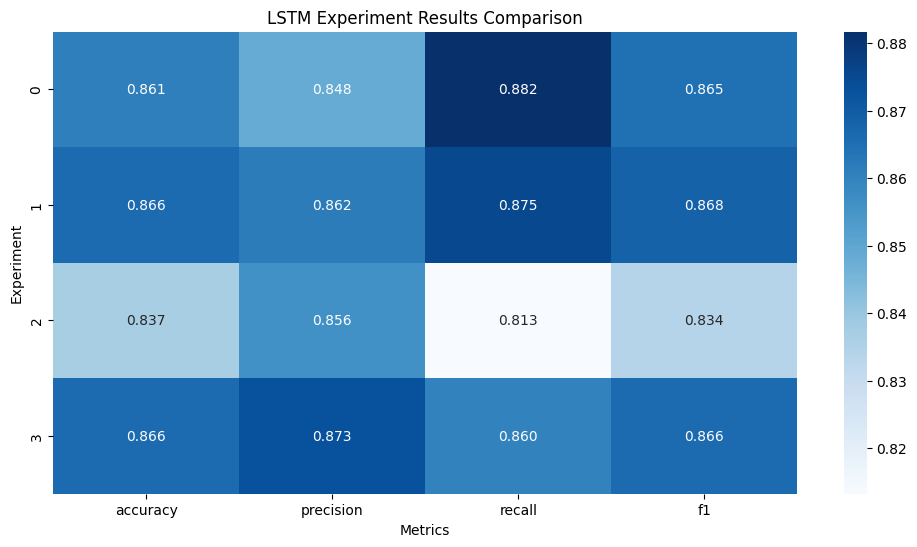

In [62]:
# Combine results
lstm_results = [metrics_1, metrics_2, metrics_3, metrics_4]
results_df = pd.DataFrame(lstm_results)

# Display combined results
print('All LSTM Experiment Results:')
print(results_df[['embedding_dim', 'lstm_units', 'dropout_rate', 'learning_rate', 'batch_size', 'optimizer', 'accuracy', 'precision', 'recall', 'f1']])

# Find best model
best_f1 = results_df['f1'].max()
best_idx = results_df['f1'].idxmax()
best_model = [model_1, model_2, model_3, model_4][best_idx]

# Save best model and tokenizer
save_model(best_model, 'best_lstm_model.keras')
joblib.dump(tokenizer, 'tokenizer.pkl')

# Visualize combined results
plt.figure(figsize=(12, 6))
sns.heatmap(results_df[['accuracy', 'precision', 'recall', 'f1']], annot=True, cmap='Blues', fmt='.3f')
plt.title('LSTM Experiment Results Comparison')
plt.xlabel('Metrics')
plt.ylabel('Experiment')
plt.show()

## Step 6: Prediction Function

Define a function to predict sentiment on new user input using the saved models.

In [63]:
def predict_sentiment(text, logistic_model, vectorizer, lstm_model, tokenizer, max_len=200):
    # Clean input text
    cleaned_text = clean_text(text)
    
    # Logistic Regression prediction
    text_vec = vectorizer.transform([cleaned_text])
    logistic_pred = logistic_model.predict(text_vec)[0]
    logistic_label = 'Positive' if logistic_pred == 1 else 'Negative'
    logistic_conf = logistic_model.predict_proba(text_vec)[0][logistic_pred]
    
    # LSTM prediction
    text_seq = tokenizer.texts_to_sequences([cleaned_text])
    text_pad = pad_sequences(text_seq, maxlen=max_len)
    lstm_pred = lstm_model.predict(text_pad, verbose=0)[0][0]
    lstm_label = 'Positive' if lstm_pred > 0.5 else 'Negative'
    lstm_conf = lstm_pred if lstm_pred > 0.5 else 1 - lstm_pred
    
    return {
        'logistic_prediction': logistic_label,
        'logistic_confidence': logistic_conf,
        'lstm_prediction': lstm_label,
        'lstm_confidence': lstm_conf
    }

## Step 7: Test Prediction

Test the prediction function with a sample input.

In [68]:
# Test prediction
sample_text = "This movie was absolutely fantastic, with great acting and a compelling story!"
prediction = predict_sentiment(sample_text, best_logistic_model, best_vectorizer, best_lstm_model, tokenizer)
print('Sample Prediction:')
print(f'Input: {sample_text}')
print(f'Logistic Regression: {prediction["logistic_prediction"]} (Confidence: {prediction["logistic_confidence"]:.4f})')
print(f'LSTM: {prediction["lstm_prediction"]} (Confidence: {prediction["lstm_confidence"]:.4f})')

Sample Prediction:
Input: This movie was absolutely fantastic, with great acting and a compelling story!
Logistic Regression: Positive (Confidence: 0.9568)
LSTM: Positive (Confidence: 0.9388)


## Step 8: How to Use Saved Models

To make predictions on new data, load the saved models and components:

In [69]:
from tensorflow.keras.models import load_model
import joblib

# Load saved models
logistic_model = joblib.load('/Users/samenergy/Documents/Projects/alu-ml_tech1-assignment/notebooks/models/best_logistic_model.pkl')
vectorizer = joblib.load('/Users/samenergy/Documents/Projects/alu-ml_tech1-assignment/notebooks/models/vectorizer.pkl')
lstm_model = load_model('/Users/samenergy/Documents/Projects/alu-ml_tech1-assignment/notebooks/models/best_lstm_model.keras')
tokenizer = joblib.load('/Users/samenergy/Documents/Projects/alu-ml_tech1-assignment/notebooks/models/tokenizer.pkl')

# Predict on new text
new_text = "The plot was not good."
result = predict_sentiment(new_text, logistic_model, vectorizer, lstm_model, tokenizer)
print(result)

{'logistic_prediction': 'Negative', 'logistic_confidence': np.float64(0.6475992537890459), 'lstm_prediction': 'Negative', 'lstm_confidence': np.float32(0.58423626)}
